# Figure 23 Data Generation

This notebook processes raw two-point correlation experimental data to generate processed data for Figure 1.

## Process:
1. Load raw experimental data from UUIDs (high and low field)
2. Process data (extract chi1 and chi12 correlation parameters)
3. Save processed data for plotting


In [1]:
# Import common utilities
import sys
from pathlib import Path
import importlib

# Add common directory to path (works in Jupyter notebooks)
common_path = Path().resolve().parent / 'common_scripts'
sys.path.insert(0, str(common_path))

from raw_data_loader import load_raw_data_by_uuid
from data_saver import save_figure_data
import data_processor as processor
import numpy as np
import correlation_fun
# Reload modules to ensure latest changes
importlib.reload(processor)
importlib.reload(correlation_fun)


data_path = Path().resolve().parent / 'data'
# Data path

figure_path = Path().resolve().parent / 'figures'


# Alias for convenience
load_by_uuid = load_raw_data_by_uuid


## Load Raw Data

Load raw experimental data for two-point correlation measurements (high and low field).


In [2]:
# Low field data UUIDs
# S1: Reference position
# S2: Single-dot measurements at different positions
# S12: Two-point correlation measurements
low_field_uuids = {
    "S1": "1730672289460108893",  # Reference position
    "S2": "1730750147026108893",  # Single-dot measurements
    "S12": "1730827675550108893"  # Two-point correlations (CORRECTED)
}

# High field data UUIDs (75mV)
high_field_uuids = {
    "S1": "1727225883960108893",  # Reference position
    "S2": "1727226751312108893",  # Single-dot measurements
    "S12": "1727224984279108893"  # Two-point correlations
}

# Load low field data
print("Loading low field data...")
data_low = {}
for key, uuid in low_field_uuids.items():
    dataset = load_by_uuid(uuid, data_path)
    if dataset is None:
        print(f"Warning: Failed to load {key} with UUID {uuid}")
    else:
        data_low[key] = dataset
        print(f"✓ Loaded {key}")

# Load high field data
print("\nLoading high field data...")
data_high = {}
for key, uuid in high_field_uuids.items():
    dataset = load_by_uuid(uuid, data_path)
    if dataset is None:
        print(f"Warning: Failed to load {key} with UUID {uuid}")
    else:
        data_high[key] = dataset
        print(f"✓ Loaded {key}")


Loading low field data...
✓ Loaded S1
✓ Loaded S2
✓ Loaded S12

Loading high field data...
✓ Loaded S1
✓ Loaded S2
✓ Loaded S12


In [3]:
# Extract low field data
# Low field uses m1_3() measurement channel (based on original notebook)
S1_low = data_low["S1"].m1_3()    # Reference position measurements
S2_low = data_low["S2"].m1_3()    # Shuttled position measurements
S12_low = data_low["S12"].m1_3()  # Cross-correlation measurements

# Extract time arrays
wait_times12 = data_low["S12"].m1_3.y()      # Wait times for S12 and S2
wait_times1 = data_low["S2"].m1_3.y()
wait_times_ref_low = data_low["S1"].m1_3.x()   # Wait times for reference S1

# Calculate shuttling distances in nm
# Formula: (20 - position) * 0.06 * 180
shuttling_distances_low = (20 - data_low["S12"].m1_3.x()) * 0.06 * 180

# Use wait_times12 for S12 and S2, wait_times_ref_low for S1
wait_times_low = wait_times1

print(f"Low field data shapes:")
print(f"  S1 (reference): {S1_low.shape}")
print(f"  S2 (single-dot): {S2_low.shape}")
print(f"  S12 (two-point): {S12_low.shape}")
print(f"  Wait times (S12/S2): {wait_times_low.shape}")
print(f"  Wait times (S1 ref): {wait_times_ref_low.shape}")
print(f"  Positions: {len(shuttling_distances_low)}")
print(f"  Shuttling positions: {data_low['S12'].m1_3.x()}")


Low field data shapes:
  S1 (reference): (200,)
  S2 (single-dot): (18, 180)
  S12 (two-point): (18, 180)
  Wait times (S12/S2): (180,)
  Wait times (S1 ref): (200,)
  Positions: 18
  Shuttling positions: [ 0.          1.05882353  2.11764706  3.17647059  4.23529412  5.29411765
  6.35294118  7.41176471  8.47058824  9.52941176 10.58823529 11.64705882
 12.70588235 13.76470588 14.82352941 15.88235294 16.94117647 18.        ]


In [4]:
importlib.reload(processor)

# Process low field: chi1 (single-dot) parameters
params_chi1_low = []
guess = {
    "T2": 5000,
    "n": 1.5,
    "freq": 1e-2
}

data1_ref = S1_low.copy()
if len(data1_ref.shape) > 1:
    data1_ref = data1_ref[0]
data1_ref = data1_ref - np.mean(data1_ref)

A, A_err, T2, T2_err, n, n_err, t_data, envelope, y_detrended, phi, f, f_err, B = \
    processor.get_fit_hilbert_drift(data1_ref, wait_times_ref_low, guess, use_hilbert=False)
sig = 1 / np.sqrt(2) / np.pi / T2
params_chi1_low.append({
    'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
    'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
    'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': 0,
    'envelope': envelope, 't_data': t_data
})

for i in range(S2_low.shape[0]):
    if len(S2_low.shape) == 2:
        data2 = S2_low[i, :].copy()
    else:
        data2 = S2_low[i].copy()
    data2 = data2 - np.mean(data2)
    
    A, A_err, T2, T2_err, n, n_err, t_data, envelope, y_detrended, phi, f, f_err, B = \
        processor.get_fit_hilbert_drift(data2, wait_times_low, guess, use_hilbert=False)
    sig = 1 / np.sqrt(2) / np.pi / T2
    params_chi1_low.append({
        'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
        'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
        'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': shuttling_distances_low[i],
        'envelope': envelope, 't_data': t_data
    })

print(f"Processed {len(params_chi1_low)} chi1 (single-dot) positions")




Processed 19 chi1 (single-dot) positions


In [5]:
# Process low field: chi12 (two-point) parameters
params_chi12_low = []

for i in range(S12_low.shape[0]):
    if len(S12_low.shape) == 2:
        data12 = S12_low[i, :].copy()
    else:
        data12 = S12_low[i].copy()
    data12 = data12 - np.mean(data12)
    
    T2_xn = params_chi1_low[0]["T2"]
    alpha_xn = params_chi1_low[0]["n"]
    T2_xm = params_chi1_low[i+1]["T2"]
    alpha_xm = params_chi1_low[i+1]["n"]
  
    A, A_err, T2, T2_err, n, n_err, t_data, envelope, y_detrended, phi, f, f_err, B = \
        processor.get_fit_hilbert_drift(data12, wait_times12, guess, use_hilbert=False)
    
    T12eff, alpha12eff = correlation_fun.calculate_chi_with_background_corrected(
        [T2_xn, T2_xm], [alpha_xn, alpha_xm], 2, np.eye(2), 1e99, 2
    )
    
    sig = 1 / np.sqrt(2) / np.pi / T2
    rnm, rnm_err, chi_dc_fit = processor.fit_rnm(wait_times12, 2*envelope/A, T2_xn, T2_xm, alpha_xn, alpha_xm, 0, [-2,2])
    
    params_chi12_low.append({
        'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
        'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
        'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': shuttling_distances_low[i],
        'rnm': rnm, 'rnm_err': rnm_err, 'T12eff': T12eff, 'alpha12eff': alpha12eff,
        'envelope': envelope, 't_data': t_data
    })

print(f"Processed {len(params_chi12_low)} chi12 (two-point) positions")

params_chi12_low = sorted(params_chi12_low, key=lambda p: p['x'])
params_chi1_low = sorted(params_chi1_low, key=lambda d: d['x'])
params_low = {"chi1": params_chi1_low, "chi12": params_chi12_low}




Processed 18 chi12 (two-point) positions


In [7]:
# Extract high field data
m1_S1_high = data_high["S1"].m1_5()
m1_S2_high = data_high["S2"].m1_5()
m1_S12_high = data_high["S12"].m1_5()

S1_high = m1_S1_high[0, 0]
S2_high = m1_S2_high[0]
S12_high = m1_S12_high[0]

wait_times_high = data_high["S12"].m1_5.k()
wait_times_ref_high = data_high["S1"].m1_5.k()

CV_times = np.array([1., 6.28571429, 11.57142857, 16.85714286, 22.14285714, 27.42857143, 32.71428571, 38.])
shuttling_distances_high = 216 - CV_times * 0.03 * 180

print(f"High field data shapes:")
print(f"  S1 (reference): {S1_high.shape}")
print(f"  S2 (single-dot): {S2_high.shape}")
print(f"  S12 (two-point): {S12_high.shape}")
print(f"  Wait times (S12/S2): {wait_times_high.shape}")
print(f"  Wait times (S1 ref): {wait_times_ref_high.shape}")
print(f"  Positions: {len(shuttling_distances_high)}")


High field data shapes:
  S1 (reference): (70,)
  S2 (single-dot): (8, 70)
  S12 (two-point): (8, 70)
  Wait times (S12/S2): (70,)
  Wait times (S1 ref): (70,)
  Positions: 8


In [8]:
# Process high field: chi1 (single-dot) parameters
params_chi1_high = []

data1_ref = S1_high.copy()
data1_ref -= np.mean(data1_ref)
guess_ref = {"T2": 3000, "n": 1.5, "freq": 0.01}
A, A_err, T2, T2_err, n, n_err, t_data, y_detrended, envelope, phi, f, f_err, B = \
    processor.get_fit_hilbert_drift(data1_ref, wait_times_ref_high, guess_ref, use_hilbert=True, window_size=10)
sig = 1 / np.sqrt(2) / np.pi / T2
params_chi1_high.append({
    'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
    'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
    'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': 0,
    'envelope': envelope, 't_data': t_data
})

for i in range(S2_high.shape[0]):
    data2 = S2_high[i, :].copy()
    data2 -= np.mean(data2)
    guess = {"T2": 4000, "n": 2, "freq": 0.01}
    A, A_err, T2, T2_err, n, n_err, t_data, y_detrended, envelope, phi, f, f_err, B = \
        processor.get_fit_hilbert_drift(data2, wait_times_high, guess, use_hilbert=True, window_size=20)
    sig = 1 / np.sqrt(2) / np.pi / T2
    params_chi1_high.append({
        'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
        'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
        'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': shuttling_distances_high[i],
        'envelope': envelope, 't_data': t_data
    })




In [9]:
# Process high field: chi12 (two-point) parameters
params_chi12_high = []

for i in range(S12_high.shape[0]):
    data12 = S12_high[i, :].copy()
    data12 -= np.mean(data12)
    
    T2_xn = params_chi1_high[0]["T2"]
    alpha_xn = params_chi1_high[0]["n"]
    T2_xm = params_chi1_high[i+1]["T2"]
    alpha_xm = params_chi1_high[i+1]["n"]
    freq = params_chi1_high[0]["freq"]
    
    guess = {"T2": 4000, "n": 2, "freq": 0.01}
    A, A_err, T2, T2_err, n, n_err, t_data, envelope, y_detrended, phi, f, f_err, B = \
        processor.get_fit_hilbert_drift(data12, wait_times_high, guess, use_hilbert=True, window_size=20)
    
    T12eff, alpha12eff = correlation_fun.calculate_chi_with_background_corrected(
        [T2_xn, T2_xm], [alpha_xn, alpha_xm], 2, np.eye(2), 1e99, 2
    )
    
    sig = 1 / np.sqrt(2) / np.pi / T2
    rnm, rnm_err, chi_dc_fit = processor.fit_rnm(wait_times_high, 2*envelope/A, T2_xn, T2_xm, alpha_xn, alpha_xm, 0, [-2,2])

    params_chi12_high.append({
        'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
        'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
        'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': shuttling_distances_high[i],
        'rnm': rnm, 'rnm_err': rnm_err, 'T12eff': T12eff, 'alpha12eff': alpha12eff,
        'envelope': envelope, 't_data': t_data
    })

print(f"Processed {len(params_chi12_high)} chi12 (two-point) positions")

params_chi1_high = sorted(params_chi1_high, key=lambda d: d['x'])
params_chi12_high = sorted(params_chi12_high, key=lambda d: d['x'])
params_high = {"chi1": params_chi1_high, "chi12": params_chi12_high}



Processed 8 chi12 (two-point) positions


In [10]:
# Save low field data
save_figure_data(
    params_low,
    figure_number="fig23",
    filename="fig23_low.pkl",
    metadata={
        "field": "low",
        "description": "Two-point correlation parameters for low field",
        "shuttling_distances": shuttling_distances_low.tolist()
    }
)

# Save high field data (75mV)
save_figure_data(
    params_high,
    figure_number="fig23",
    filename="fig23_high_75mV.pkl",
    metadata={
        "field": "high",
        "voltage": "75mV",
        "description": "Two-point correlation parameters for high field (75mV)",
        "shuttling_distances": shuttling_distances_high.tolist()
    }
)

print("✓ Data saved successfully!")


✓ Saved fig23 data to /Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/processed_data/fig23/fig23_low.pkl
  Metadata saved to /Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/processed_data/fig23/fig23_low.json
✓ Saved fig23 data to /Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/processed_data/fig23/fig23_high_75mV.pkl
  Metadata saved to /Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/processed_data/fig23/fig23_high_75mV.json
✓ Data saved successfully!


## Apendix I: raw data

Create comprehensive plots showing T2 times, exponents, and individual decay curves for both single-dot and two-point correlation measurements.


In [11]:
# Import plotting utilities
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [37]:
# Comprehensive plotting function adapted from two_point_gen.ipynb
def create_comprehensive_plot(params_dict, shuttling_distances, field_label, S1_data, S2_data, S12_data, wait_times1, wait_times12, wait_times_ref, single_color='tab:blue', two_point_color='tab:red'):
    """
    Create comprehensive plot showing:
    - First row: T2(n) - single-dot decay times vs position
    - Second row: alpha(n) - single-dot exponents vs position
    - Third row: data and fit for each position (single-dot measurements, including reference)
    - Fourth row: T2(0,n) two point - two-point correlation decay times vs position
    - Fifth row: alpha(0,n) two point - two-point correlation exponents vs position
    - Sixth row: data and fit for each position (two-point correlation measurements, first column empty)
    
    Parameters:
    - single_color: Color for single-dot plots (default: 'tab:blue')
    - two_point_color: Color for two-point correlation plots (default: 'tab:red')
    """
    params_chi1 = params_dict["chi1"]
    params_chi12 = params_dict["chi12"]
    
    # Extract parameters for plotting
    # Reference position (index 0)
    ref_distance = params_chi1[0]["x"]  # Should be 0
    ref_T2 = params_chi1[0]["T2"]/1000  # Convert to microseconds
    ref_T2_err = params_chi1[0]["dT"]/1000
    ref_alpha = params_chi1[0]["n"]
    ref_alpha_err = params_chi1[0]["dn"]
    
    # Single-dot measurements (skip reference position at index 0)
    chi1_distances = [p["x"] for p in params_chi1[1:]]
    chi1_T2 = [p["T2"]/1000 for p in params_chi1[1:]]  # Convert to microseconds
    chi1_T2_err = [p["dT"]/1000 for p in params_chi1[1:]]
    chi1_alpha = [p["n"] for p in params_chi1[1:]]
    chi1_alpha_err = [p["dn"] for p in params_chi1[1:]]
    
    # Include reference in the lists for plotting
    chi1_distances_with_ref = chi1_distances + [ref_distance] 
    chi1_T2_with_ref = chi1_T2 + [ref_T2] 
    chi1_T2_err_with_ref = chi1_T2_err + [ref_T2_err]
    chi1_alpha_with_ref = chi1_alpha + [ref_alpha] 
    chi1_alpha_err_with_ref = chi1_alpha_err + [ref_alpha_err] 
    

    

    # Two-point correlation measurements (params_chi12 doesn't include reference)
    chi12_distances = [p["x"] for p in params_chi12]
    chi12_T2 = [p["T2"]/1000 for p in params_chi12]  # Use T12eff
    chi12_T2_err = [p["dT"]/1000 for p in params_chi12]  # Approximate error
    chi12_alpha = [p["n"] for p in params_chi12]
    chi12_alpha_err = [p["dn"] for p in params_chi12]  # Approximate error
    
    # Number of positions (excluding reference)
    N_cols_shuttled = len(chi1_distances)
    # For single-dot plots, include reference position (add 1 column)
    N_cols_single = N_cols_shuttled + 1
    # For two-point plots, same number but first column will be empty
    N_cols_two = N_cols_shuttled + 1
    
    # Define height ratios for GridSpec
    nrows_logical = 6
    height_ratios_logical = [1, 1, 1.5, 1, 1, 1.5]
    
    # Use max columns for GridSpec
    N_cols_max = max(N_cols_single, N_cols_two)
    
    fig = plt.figure(figsize=(8, 7.5/6.5*8.5))
    gs = gridspec.GridSpec(nrows_logical, N_cols_max, figure=fig,
                           height_ratios=height_ratios_logical,
                           hspace=0.45, wspace=0.0)
    
    # Sort single-dot data by distance for plotting
    chi1_sort_indices = np.argsort(chi1_distances_with_ref)
    chi1_distances_sorted = [chi1_distances_with_ref[i] for i in chi1_sort_indices]
    chi1_T2_sorted = [chi1_T2_with_ref[i] for i in chi1_sort_indices]
    chi1_T2_err_sorted = [chi1_T2_err_with_ref[i] for i in chi1_sort_indices]
    chi1_alpha_sorted = [chi1_alpha_with_ref[i] for i in chi1_sort_indices]
    chi1_alpha_err_sorted = [chi1_alpha_err_with_ref[i] for i in chi1_sort_indices]
    
    # Row 1: T2(n) - single-dot decay times (including reference)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.errorbar(chi1_distances_sorted, chi1_T2_sorted, yerr=chi1_T2_err_sorted, fmt='o-', 
                 color=single_color, ecolor=single_color, capsize=3, markersize=5, 
                 markerfacecolor='white', markeredgecolor=single_color, label='Single-position')
    ax1.set_ylabel(r'$T_2^*(x_n)$ ($\mu$s)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    # Row 2: alpha(n) - single-dot exponents (including reference)
    ax2 = fig.add_subplot(gs[1, :], sharex=ax1)
    ax2.errorbar(chi1_distances_sorted, chi1_alpha_sorted, yerr=chi1_alpha_err_sorted, fmt='o-',
                 color=single_color, ecolor=single_color, capsize=3, markersize=5,
                 markerfacecolor='white', markeredgecolor=single_color)
    ax2.set_ylabel(r'$\alpha(x_n)$')
    ax2.set_xlabel('Position $x_n$ (nm)')
    ax2.set_ylim(0.9, 2.5)
    ax2.grid(True, linestyle=':')
    
    # Row 3: Individual decay plots for single-dot (including reference position)
    # Create mapping from distance-sorted order to column positions
    # All distances: reference (index 0) + shuttled positions (indices 1, 2, ...)
    all_distances = [ref_distance] + chi1_distances
    all_indices = [0] + [i+1 for i in range(N_cols_shuttled)]
    
    # Sort by distance and create column mapping
    sorted_pairs = sorted(zip(all_distances, all_indices))
    index_to_col = {}
    for col_idx, (dist, orig_idx) in enumerate(sorted_pairs):
        index_to_col[orig_idx] = col_idx
    
    # Reference position (index 0)
    # Load raw data
    data1_ref = S1_data.copy()
    if len(data1_ref.shape) > 1:
        data1_ref = data1_ref[0]  # Take first if 2D
    data1_ref = data1_ref - np.mean(data1_ref)  # Detrend
    
    p_chi1_ref = params_chi1[0]
    A1_ref, T1_ref, n1_ref = p_chi1_ref["A"], p_chi1_ref["T2"], p_chi1_ref["n"]
    
    # Scale raw data by fit amplitude
    amplitudes1_ref = data1_ref / A1_ref  # Scale by fit amplitude
    t_data1_ref = wait_times_ref  # Use original wait times
    
    # Create fit curve for reference (with sign)
    # Convert time to microseconds
    wait_times_ref_us = wait_times_ref / 1000
    fit_x1_ref = np.linspace(wait_times_ref_us[0], wait_times_ref_us[-1], 100)
    envelope1_ref = processor.envelope_func(fit_x1_ref * 1000, A1_ref, T1_ref, n1_ref) / A1_ref  # Scale by A
    # Also plot negative envelope
    envelope1_ref_neg = -processor.envelope_func(fit_x1_ref * 1000, A1_ref, T1_ref, n1_ref) / A1_ref
    
    # Plot reference position in column determined by distance sorting
    col_ref = index_to_col[0]
    ax_single_ref = fig.add_subplot(gs[2, col_ref])
    t_data1_ref_us = t_data1_ref / 1000
    ax_single_ref.scatter(t_data1_ref_us, amplitudes1_ref, s=2, alpha=0.7, color=single_color)
    # Add connecting line between dots
    ax_single_ref.plot(t_data1_ref_us, amplitudes1_ref, color=single_color, lw=1, alpha=0.4)
    ax_single_ref.plot(fit_x1_ref, envelope1_ref, color=single_color, lw=2)
    ax_single_ref.plot(fit_x1_ref, envelope1_ref_neg, color=single_color, lw=2)
    ax_single_ref.grid(True, linestyle='-', lw=0.4)
    ax_single_ref.set_ylim(-0.5, 0.5)
    ax_single_ref.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax_single_ref.set_ylabel('Amp. Single')
    
    # Sort data arrays by x to match sorted parameters (params are already sorted by x)
    # Create mapping: for each sorted param, find its original index in shuttling_distances
    chi1_sorted_to_original = []
    for p in params_chi1[1:]:  # Skip reference at index 0, params are already sorted by x
        # Find original index by matching distance
        original_idx = np.where(np.abs(shuttling_distances - p["x"]) < 1e-6)[0]
        if len(original_idx) > 0:
            chi1_sorted_to_original.append(original_idx[0])
        else:
            # Fallback: use index based on position in sorted list
            chi1_sorted_to_original.append(len(chi1_sorted_to_original))
    
    # Sort S2_data to match sorted parameter order (sorted by x, with 0 near smallest)
    if len(S2_data.shape) == 2:
        S2_data_sorted = S2_data[chi1_sorted_to_original, :]
    else:
        S2_data_sorted = S2_data[0, chi1_sorted_to_original, :]
    
    # Then plot shuttled positions (already sorted by x)
    for sorted_idx in range(N_cols_shuttled):
        col = index_to_col[sorted_idx+1]  # Use distance-sorted column mapping
        
        # Load raw data
        if len(S2_data_sorted.shape) == 2:
            data2 = S2_data_sorted[sorted_idx, :].copy()
        else:
            data2 = S2_data_sorted[sorted_idx].copy()
        data2 = data2 - np.mean(data2)  # Detrend
        
        # Get fit parameters - already sorted by x
        p_chi1 = params_chi1[sorted_idx+1]
        A1, T1, n1 = p_chi1["A"], p_chi1["T2"], p_chi1["n"]
        
        # Scale raw data by fit amplitude
        amplitudes1 = data2 / A1  # Scale by fit amplitude
        t_data1 = wait_times1  # Use original wait times
        
        # Create fit curve (with sign)
        # Convert time to microseconds
        wait_times_us = wait_times1 / 1000
        fit_x1 = np.linspace(wait_times_us[0], wait_times_us[-1], 100)
        envelope1 = processor.envelope_func(fit_x1 * 1000, A1, T1, n1) / A1  # Scale by A
        envelope1_neg = -processor.envelope_func(fit_x1 * 1000, A1, T1, n1) / A1
        
        # Plot single-dot data
        ax_single = fig.add_subplot(gs[2, col])
        t_data1_us = t_data1 / 1000
        ax_single.scatter(t_data1_us, amplitudes1, s=2, alpha=0.7, color=single_color)
        # Add connecting line between dots
        ax_single.plot(t_data1_us, amplitudes1, color=single_color, lw=1, alpha=0.4)
        ax_single.plot(fit_x1, envelope1, color=single_color, lw=1.4)
        ax_single.plot(fit_x1, envelope1_neg, color=single_color, lw=1.4)
        ax_single.grid(True, linestyle='-', lw=0.4)
        ax_single.set_ylim(-0.5, 0.5)
        ax_single.set_yticks([-0.4,-0.2,0,0.2,0.4])
        ax_single.set_yticklabels([])
        ax_single_ref.set_xlim(ax_single.get_xlim())
        ax_single_ref.set_xticks([10])
        ax_single.set_xticks([10])

        if col == N_cols_max//2:  # Middle column
            ax_single.set_xlabel(r'Time ($\mu$s)')
     
    # Sort two-point data by distance for plotting
    chi12_sort_indices = np.argsort(chi12_distances)
    chi12_distances_sorted = [chi12_distances[i] for i in chi12_sort_indices]
    chi12_T2_sorted = [chi12_T2[i] for i in chi12_sort_indices]
    chi12_T2_err_sorted = [chi12_T2_err[i] for i in chi12_sort_indices]
    chi12_alpha_sorted = [chi12_alpha[i] for i in chi12_sort_indices]
    chi12_alpha_err_sorted = [chi12_alpha_err[i] for i in chi12_sort_indices]
    
    # Row 4: T2(0,n) two point - two-point correlation decay times
    ax3 = fig.add_subplot(gs[3, :], sharex=ax1)
    ax3.errorbar(chi12_distances_sorted, chi12_T2_sorted, yerr=chi12_T2_err_sorted, fmt='s-',
                 color=two_point_color, ecolor=two_point_color, capsize=3, markersize=5,
                 markerfacecolor='white', markeredgecolor=two_point_color, label='Two-point')
    ax3.set_ylabel(r'$T_2^{*,0n}$ ($\mu$s)')
    ax3.legend()
    ax3.grid(True, linestyle=':')
    
    # Row 5: alpha(0,n) two point - two-point correlation exponents
    ax4 = fig.add_subplot(gs[4, :], sharex=ax1)
    ax4.errorbar(chi12_distances_sorted, chi12_alpha_sorted, yerr=chi12_alpha_err_sorted, fmt='s-',
                 color=two_point_color, ecolor=two_point_color, capsize=3, markersize=5,
                 markerfacecolor='white', markeredgecolor=two_point_color)
    ax4.set_ylabel(r'$\alpha_{0n}$')
    ax4.grid(True, linestyle=':')
    ax4.set_xlabel(r'Position $x_n$ (nm)')
    ax4.set_ylim(0.9, 2.5)
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(-1,220)

    # Row 6: Individual decay plots for two-point (first column empty)
    # Create column mapping for two-point: skip column 0, then use distance-sorted order
    # Map shuttled indices to columns, but shift by 1 to leave column 0 empty
    two_point_col_mapping = {}
    sorted_shuttled = sorted(zip(chi1_distances, range(N_cols_shuttled)))
    for col_idx, (dist, orig_i) in enumerate(sorted_shuttled):
        two_point_col_mapping[orig_i] = col_idx + 1  # Start from column 1
    
    # Sort S12_data to match sorted parameter order (params_chi12 is already sorted by x)
    chi12_sorted_to_original = []
    for p in params_chi12:  # params_chi12 is already sorted by x
        # Find original index by matching distance
        original_idx = np.where(np.abs(shuttling_distances - p["x"]) < 1e-6)[0]
        if len(original_idx) > 0:
            chi12_sorted_to_original.append(original_idx[0])
        else:
            # Fallback: use index based on position in sorted list
            chi12_sorted_to_original.append(len(chi12_sorted_to_original))
    
    if len(S12_data.shape) == 2:
        S12_data_sorted = S12_data[chi12_sorted_to_original, :]
    else:
        S12_data_sorted = S12_data[0, chi12_sorted_to_original, :]
    
    for sorted_idx in range(N_cols_shuttled):
        # Find which chi1 index this corresponds to for column mapping (both are sorted by x)
        chi12_dist = params_chi12[sorted_idx]["x"]
        chi1_match_idx = None
        for j, chi1_dist in enumerate(chi1_distances):
            if abs(chi1_dist - chi12_dist) < 1e-6:
                chi1_match_idx = j
                break
        if chi1_match_idx is None:
            chi1_match_idx = sorted_idx  # Fallback
        
        col = two_point_col_mapping[chi1_match_idx]  # Use distance-sorted column mapping (column 0 is empty)
        
        # Load raw data
        if len(S12_data_sorted.shape) == 2:
            data12 = S12_data_sorted[sorted_idx, :].copy()
        else:
            data12 = S12_data_sorted[sorted_idx].copy()
        data12 = data12 - np.mean(data12)  # Detrend
        
        # Get fit parameters - already sorted by x
        p_chi12 = params_chi12[sorted_idx]
        A12, T12, n12 = p_chi12["A"], p_chi12["T2"], p_chi12["n"]
        
        # Scale raw data by fit amplitude
        amplitudes12 = data12 / A12  # Scale by fit amplitude
        t_data12 = wait_times12 / 1000  # Use original wait times, convert to microseconds
        
        # Create fit curve (with sign)
        # Convert time to microseconds
        wait_times_us = wait_times12 / 1000
        fit_x12 = np.linspace(wait_times_us[0], wait_times_us[-1], 100)
        envelope12 = processor.envelope_func(fit_x12 * 1000, A12, T12, n12) / A12  # Scale by A
        envelope12_neg = -processor.envelope_func(fit_x12 * 1000, A12, T12, n12) / A12
        
        # Plot two-point data
        ax_two = fig.add_subplot(gs[5, col])
        ax_two.scatter(t_data12, amplitudes12, s=2, alpha=0.7, color=two_point_color)
        # Add connecting line between dots
        ax_two.plot(t_data12, amplitudes12, color=two_point_color, lw=0.5, alpha=0.4)
        ax_two.plot(fit_x12, envelope12, color=two_point_color, lw=2)
        ax_two.plot(fit_x12, envelope12_neg, color=two_point_color, lw=2)
        ax_two.grid(True, linestyle='-', lw=0.4)
        ax_two.set_ylim(-0.5, 0.5)
        ax_two.set_xticks([10])
        if col == N_cols_max//2:  # Middle column
            ax_two.set_xlabel(r'Time ($\mu$s)')
        if col == 1:
            ax_two.set_ylabel('Amp. Two-point')
        else:
            plt.setp(ax_two.get_yticklabels(), visible=False)
    
    plt.subplots_adjust(left=0.08, right=0.99, top=0.99, bottom=0.05)
    plt.savefig(f'{figure_path}/app_two_point_{field_label}.pdf')
    plt.show()


Creating low-field comprehensive plot...


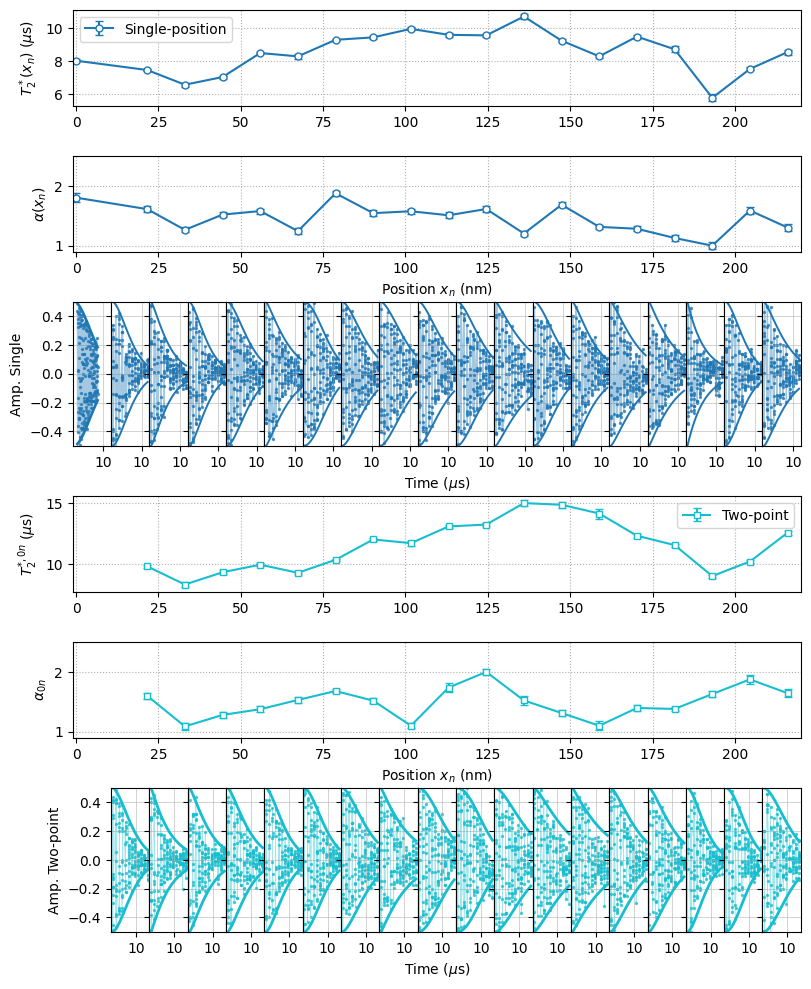

In [38]:
# Create plot for low field
print("Creating low-field comprehensive plot...")
create_comprehensive_plot(params_low, shuttling_distances_low, "low_field", 
                         S1_low, S2_low, S12_low, wait_times_low, wait_times12, wait_times_ref_low, 
                         single_color="tab:blue", two_point_color="tab:cyan")

Creating high-field comprehensive plot...


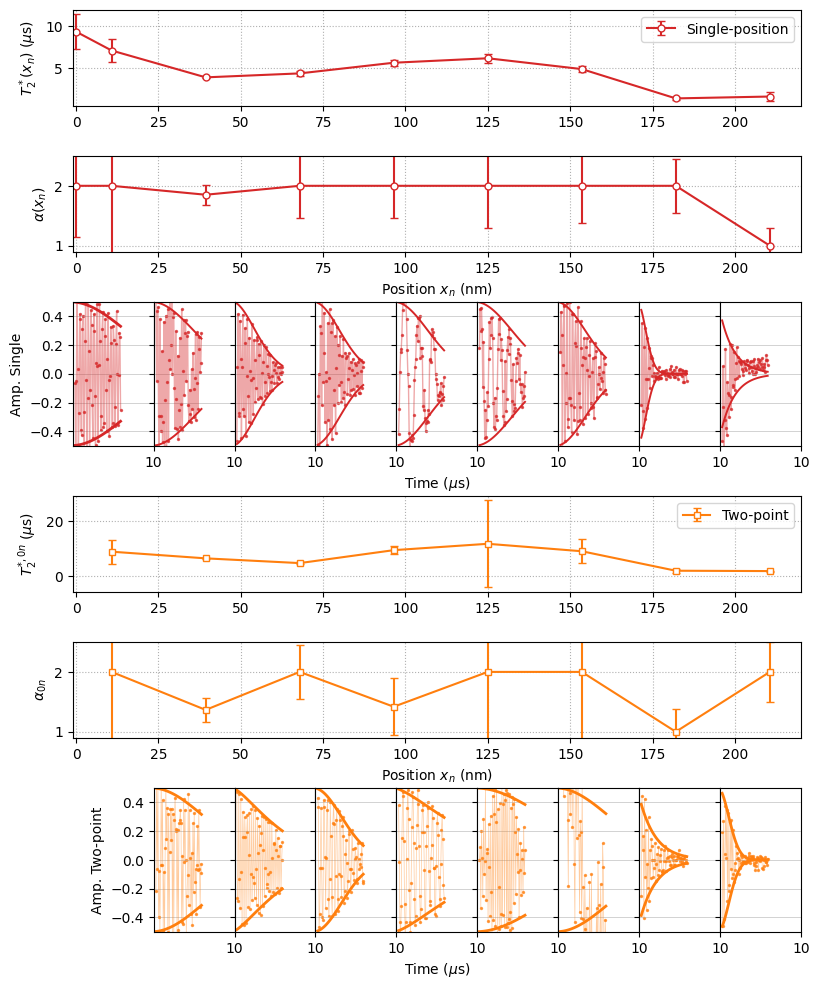

In [39]:
# Create plot for high field
print("Creating high-field comprehensive plot...")
create_comprehensive_plot(params_high, shuttling_distances_high, "high_field",
                         S1_high, S2_high, S12_high, wait_times_high, wait_times_high, wait_times_ref_high,
                         single_color="tab:red", two_point_color="tab:orange")

## Appendix H:Variability of high-field data

Process data for 65mV, 75mV, and 85mV and create Figure 18 showing chi1 T2 data and T2^0n plots for each voltage.


In [25]:
# Load data for 65mV, 75mV, 85mV
data_65mv = {"S12": {"id": 1727222345743108893}, 
             "S1": {"id": 1727223245897108893},
             "S2": {"id": 1727224112791108893}}

data_75mv = {"S12": {"id": 1727224984279108893},
             "S1": {"id": 1727225883960108893}, 
             "S2": {"id": 1727226751312108893}}

data_85mv = {"S12": {"id": 1727227620625108893},
             "S1": {"id": 1727228520034108893}, 
             "S2": {"id": 1727229387657108893}}

voltage_data_configs = [data_65mv, data_75mv, data_85mv]
voltage_labels = ['65mV', '75mV', '85mV']

# Load all voltage data
print("Loading data for 65mV, 75mV, 85mV...")
all_voltage_data = []
for m, config in enumerate(voltage_data_configs):
    print(f"\nLoading {voltage_labels[m]} data...")
    voltage_data = {}
    for key, uuid_dict in config.items():
        uuid = uuid_dict["id"]
        dataset = load_by_uuid(uuid, data_path)
        if dataset is None:
            print(f"Warning: Failed to load {key} with UUID {uuid}")
        else:
            voltage_data[key] = dataset
            print(f"✓ Loaded {key}")
    all_voltage_data.append(voltage_data)


Loading data for 65mV, 75mV, 85mV...

Loading 65mV data...
✓ Loaded S12
✓ Loaded S1
✓ Loaded S2

Loading 75mV data...
✓ Loaded S12
✓ Loaded S1
✓ Loaded S2

Loading 85mV data...
✓ Loaded S12
✓ Loaded S1
✓ Loaded S2


In [26]:
# Process data for each voltage using high-field processing approach
params_all_voltages = []

for m, voltage_data in enumerate(all_voltage_data):
    print(f"\nProcessing {voltage_labels[m]} data...")
    
    # Extract high field data (same approach as cell 9)
    m1_S1 = voltage_data["S1"].m1_5()
    m1_S2 = voltage_data["S2"].m1_5()
    m1_S12 = voltage_data["S12"].m1_5()

    S1 = m1_S1[0, 0]
    S2 = m1_S2[0]
    S12 = m1_S12[0]

    wait_times = voltage_data["S12"].m1_5.k()
    wait_times_ref = voltage_data["S1"].m1_5.k()

    CV_times = np.array([1., 6.28571429, 11.57142857, 16.85714286, 22.14285714, 27.42857143, 32.71428571, 38.])
    shuttling_distances = 216 - CV_times * 0.03 * 180

    print(f"  Data shapes: S1={S1.shape}, S2={S2.shape}, S12={S12.shape}")
    print(f"  Positions: {len(shuttling_distances)}")
    
    # Process chi1 (single-dot) parameters (same approach as cell 11)
    params_chi1 = []

    data1_ref = S1.copy()
    data1_ref -= np.mean(data1_ref)
    guess_ref = {"T2": 3000, "n": 2, "freq": 0.01}
    A, A_err, T2, T2_err, n, n_err, t_data, y_detrended, envelope, phi, f, f_err, B = \
        processor.get_fit_hilbert_drift(data1_ref, wait_times_ref, guess_ref, use_hilbert=True, window_size=10)
    sig = 1 / np.sqrt(2) / np.pi / T2
    params_chi1.append({
        'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
        'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
        'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': 0,
        'envelope': envelope, 't_data': t_data
    })

    for i in range(S2.shape[0]):
        data2 = S2[i, :].copy()
        data2 -= np.mean(data2)
        guess = {"T2": 4000, "n": 2, "freq": 0.01}
        A, A_err, T2, T2_err, n, n_err, t_data, y_detrended, envelope, phi, f, f_err, B = \
            processor.get_fit_hilbert_drift(data2, wait_times, guess, use_hilbert=True, window_size=20)
        sig = 1 / np.sqrt(2) / np.pi / T2
        params_chi1.append({
            'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
            'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
            'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': shuttling_distances[i],
            'envelope': envelope, 't_data': t_data
        })
 
    print(f"  Processed {len(params_chi1)} chi1 positions")
    
    # Process chi12 (two-point) parameters (same approach as cell 14)
    params_chi12 = []

    for i in range(S12.shape[0]):
        data12 = S12[i, :].copy()
        data12 -= np.mean(data12)
        
        T2_xn = params_chi1[0]["T2"]
        alpha_xn = params_chi1[0]["n"]
        T2_xm = params_chi1[i+1]["T2"]
        alpha_xm = params_chi1[i+1]["n"]
        freq = params_chi1[0]["freq"]
        
        guess = {"T2": 4000, "n": 2, "freq": 0.01}
        A, A_err, T2, T2_err, n, n_err, t_data, envelope, y_detrended, phi, f, f_err, B = \
            processor.get_fit_hilbert_drift(data12, wait_times, guess, use_hilbert=True, window_size=20)
        
        T12eff, alpha12eff = correlation_fun.calculate_chi_with_background_corrected(
            [T2_xn, T2_xm], [alpha_xn, alpha_xm], 2, np.eye(2), 1e99, 2
        )
        
        sig = 1 / np.sqrt(2) / np.pi / T2
        rnm, rnm_err, chi_dc_fit = processor.fit_rnm(wait_times, 2*envelope/A, T2_xn, T2_xm, alpha_xn, alpha_xm, 0, [-2,2])

        params_chi12.append({
            'A': A, 'T2': T2, 'n': n, 'phi': phi, 'freq': f, 'B': B,
            'sig': sig, 'dsig': T2_err / np.sqrt(2) / np.pi / T2**2,
            'dT': T2_err, 'dn': n_err, 'dfreq': f_err, 'x': shuttling_distances[i],
            'rnm': rnm, 'rnm_err': rnm_err, 'T12eff': T12eff, 'alpha12eff': alpha12eff,
            'envelope': envelope, 't_data': t_data
        })


    print(f"  Processed {len(params_chi12)} chi12 positions")

    params_chi1 = sorted(params_chi1, key=lambda d: d['x'])
    params_chi12 = sorted(params_chi12, key=lambda d: d['x'])
    params_voltage = {"chi1": params_chi1, "chi12": params_chi12}
    params_all_voltages.append(params_voltage)

print(f"\n✓ Processed all {len(params_all_voltages)} voltages")



Processing 65mV data...
  Data shapes: S1=(70,), S2=(8, 70), S12=(8, 70)
  Positions: 8
  Processed 9 chi1 positions
  Processed 8 chi12 positions

Processing 75mV data...
  Data shapes: S1=(70,), S2=(8, 70), S12=(8, 70)
  Positions: 8
  Processed 9 chi1 positions
  Processed 8 chi12 positions

Processing 85mV data...
  Data shapes: S1=(70,), S2=(8, 70), S12=(8, 70)
  Positions: 8
  Processed 9 chi1 positions
  Processed 8 chi12 positions

✓ Processed all 3 voltages


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_95313/3693329403.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


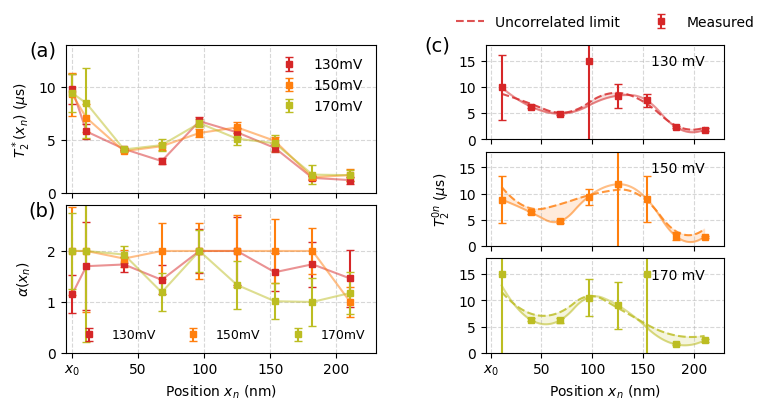

In [31]:
# Create plot with (a) chi1 T2 and (a2) alpha in left column (2 rows), and (b), (c), (d) T2^0n plots for each voltage in right column (3 rows)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

# Define three contrasting colors for 65mV, 75mV, 85mV
colors = ["tab:red", "tab:orange", "tab:olive"]
labels = ['130mV', '150mV', '170mV']

# Create figure: left column has 2 rows (T2 and alpha), right column has 3 rows (T2^0n for each voltage)
# Use 6 rows total to accommodate both: left column 2 equal sections, right column 3 equal sections
fig = plt.figure(figsize=(8.5, 4))
gs = fig.add_gridspec(6, 2, height_ratios=[1, 1, 1, 1, 1, 1], width_ratios=[1.3, 1], 
                      hspace=0.3, wspace=0.4)

# Panel (a): Top half of left column for chi1 T2 data (spans rows 0-2)
ax1 = fig.add_subplot(gs[0:3, 0])  # Spans first 3 rows, left column

# Panel (a2): Bottom half of left column for alpha data (spans rows 3-5)
ax1_alpha = fig.add_subplot(gs[3:6, 0])  # Spans last 3 rows, left column

# Panels (b), (c), (d): Each spans 2 rows in right column for T2^0n plots
ax2 = fig.add_subplot(gs[0:2, 1])  # Panel (b) for 65mV - spans rows 0-1
ax3 = fig.add_subplot(gs[2:4, 1])  # Panel (c) for 75mV - spans rows 2-3
ax4 = fig.add_subplot(gs[4:6, 1])  # Panel (d) for 85mV - spans rows 4-5
ax2_list = [ax2, ax3, ax4]

# Plot chi1 T2 data in panel (a) - all three voltages in one plot
for m in range(3):
    params = params_all_voltages[m]
    T2s = np.array([params["chi1"][k]["T2"] for k in range(9)]) / 1e3  # Convert to microseconds
    dT2s = np.array([params["chi1"][k]["dT"] for k in range(9)]) / 1e3  # Convert to microseconds
    distances1 = np.array([params["chi1"][k]["x"] for k in range(9)])
    distances1_ind = np.argsort(distances1)
    T2s = T2s[distances1_ind]
    dT2s = dT2s[distances1_ind]
    distances1 = distances1[distances1_ind]

    line = ax1.errorbar(distances1, T2s, yerr=dT2s, fmt='s', capsize=3, 
                        ms=4, color=colors[m], label=labels[m])
    ax1.plot(distances1, T2s, '-', color=colors[m], alpha=0.5)

# Plot chi1 alpha (n) data in panel (a2) - all three voltages in one plot
for m in range(3):
    params = params_all_voltages[m]
    alphas = np.array([params["chi1"][k]["n"] for k in range(9)])
    dalphas = np.array([params["chi1"][k]["dn"] for k in range(9)])
    distances1 = np.array([params["chi1"][k]["x"] for k in range(9)])
    distances1_ind = np.argsort(distances1)
    alphas = alphas[distances1_ind]
    dalphas = dalphas[distances1_ind]
    distances1 = distances1[distances1_ind]

    line = ax1_alpha.errorbar(distances1, alphas, yerr=dalphas, fmt='s', capsize=3, 
                              ms=4, color=colors[m], label=labels[m])
    ax1_alpha.plot(distances1, alphas, '-', color=colors[m], alpha=0.5)

# Plot T2^0n vs distance with uncorrelated limit for each voltage in panels (b), (c), (d)
for m in range(3):
    ax = ax2_list[m]  # Get the axis for this voltage
    params = params_all_voltages[m]
    
    # Get measured T2^0n (from chi12)
    T2_0n_measured = np.array([params["chi12"][k]["T2"] for k in range(8)]) / 1e3  # Convert to microseconds
    dT2_0n_measured = np.array([params["chi12"][k]["dT"] for k in range(8)]) / 1e3
    distances = np.array([params["chi1"][k+1]["x"] for k in range(8)])
    
    # Compute T12eff (uncorrelated limit) for each position
    T12eff_values = []
    for k in range(8):
        # Get reference position (index 0) and current position (index k+1)
        T2_xn = params["chi1"][0]["T2"]  # Reference position T2
        T2_xm = params["chi1"][k+1]["T2"]  # Current position T2
        alpha_xn = params["chi1"][0]["n"]  # Reference position alpha
        alpha_xm = params["chi1"][k+1]["n"]  # Current position alpha
        
        # Compute T12eff using uncorrelated limit (identity correlation matrix)
        T12eff, _ = correlation_fun.calculate_chi_with_background_corrected(
            [T2_xn, T2_xm], [alpha_xn, alpha_xm], 2, np.eye(2), 1e99, 2
        )
        T12eff_values.append(T12eff / 1e3)  # Convert to microseconds
    
    T12eff_values = np.array(T12eff_values)
    
    # Filter points for interpolation: skip points where error bar > 0.4*T2
    mask = dT2_0n_measured <= 0.8 * T2_0n_measured
    
    # Create filtered arrays for interpolation
    distances_filtered = distances[mask]
    T2_0n_measured_filtered = T2_0n_measured[mask]
    T12eff_values_filtered = T12eff_values[mask]
    
    # Interpolate measured and uncorrelated values (using filtered data)
    f_measured = interp1d(distances_filtered, T2_0n_measured_filtered, kind='quadratic', fill_value='extrapolate')
    f_eff = interp1d(distances_filtered, T12eff_values_filtered, kind='quadratic', fill_value='extrapolate')
    
    x_interp = np.linspace(np.min(distances), np.max(distances), 100)
    ymeasured_interp = f_measured(x_interp)
    yeff_interp = f_eff(x_interp)
    
    # Plot measured data with error bars
    line_measured = ax.errorbar(
        distances, T2_0n_measured, yerr=dT2_0n_measured,
        fmt='s', capsize=3, color=colors[m], label='Measured', ms=4
    )
    
    # Plot uncorrelated limit (dashed line)
    line_uncorr, = ax.plot(
        x_interp, yeff_interp, "--", color=colors[m], linewidth=1.5, alpha=0.8, label='Uncorrelated limit'
    )
    
    # Plot interpolated measured line
    ax.plot(x_interp, ymeasured_interp, "-", color=colors[m], alpha=0.5, linewidth=1.5)
    
    # Fill between curves
    ax.fill_between(x_interp, yeff_interp, ymeasured_interp, 
                     where=(yeff_interp > ymeasured_interp), 
                     color=colors[m], alpha=0.15)

# Style panel (a) - chi1 T2
ax1.set_ylabel(r"$T_2^*(x_n)$ ($\mu$s)")
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xlim(-5, 230)
ax1.set_xticks([0, 50, 100, 150, 200])
ax1.set_xticklabels([])  # Remove x-axis labels for top panel
ax1.set_yticks([0, 5, 10, 15])
ax1.set_ylim(0, 14)
ax1.legend(frameon=False, loc='upper right')

# Style panel (a2) - chi1 alpha
ax1_alpha.set_ylabel(r"$\alpha(x_n)$")
ax1_alpha.set_xlabel("Position $x_n$ (nm)")
ax1_alpha.grid(True, linestyle='--', alpha=0.5)
ax1_alpha.set_xlim(-5, 230)
ax1_alpha.set_xticks([0, 50, 100, 150, 200])
ax1_alpha.set_xticklabels([r"$x_0$", 50, 100, 150, 200])
ax1_alpha.set_ylim(0, 2.9)
# Set y-axis limits based on typical alpha values (adjust if needed)
ax1_alpha.legend(frameon=False, loc='lower center', ncol=3, fontsize = 9)

# Style panels (b), (c), (d) - T2^0n plots
panel_labels_t2 = ['(c)']
label = ["130 mV", "150 mV", "170 mV"]
for m, ax in enumerate(ax2_list):
    if m==1:
        ax.set_ylabel(r"$T_2^{0n}$ ($\mu$s)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(-5, 230)
    ax.set_xticks([0, 50, 100, 150, 200])
    if m == 2:  # Only bottom panel has xlabel
        ax.set_xlabel("Position $x_n$ (nm)")
        ax.set_xticklabels([r"$x_0$", 50, 100, 150, 200])
    else:
        ax.set_xticklabels([])  # Remove x-axis labels for upper panels
    ax.set_yticks([0, 5, 10, 15])
    ax.set_ylim(0, 18)
    if m==0:
        ax.legend(frameon=False, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45))
    # Add panel label
    if m==0:
        ax.text(-0.15, 1.1, panel_labels_t2[m], transform=ax.transAxes, 
            fontsize=14, va='top', ha='right')
    ax.text(0.92,0.9, label[m], transform=ax.transAxes, va='top', ha='right')

# Add panel labels for (a) and (a2)
ax1.text(-0.03, 1.03, '(a)', transform=ax1.transAxes, 
         fontsize=14, va='top', ha='right')
ax1_alpha.text(-0.03, 1.03, '(b)', transform=ax1_alpha.transAxes, 
               fontsize=14, va='top', ha='right')

# Align y-labels
all_axes = [ax1, ax1_alpha] + ax2_list
fig.align_ylabels(all_axes)

plt.tight_layout()
plt.savefig(f"{figure_path}/app_two_point_voltaes.pdf", bbox_inches='tight', dpi=300)
plt.show()
